# Proyecto final: Clasificación de aves

Alumna: Estephania Pivac Alcaraz

## 0. Cargar las librerías necesarias

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout, Rescaling, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import json
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import cv2
from google.colab import drive

In [2]:
t = time.time()

## 1. Cargar el conjunto de datos de las aves

In [3]:
# Montar Google Drive
drive.mount('/content/drive')

# Ruta a la carpeta birds_classification en Google Drive
data_folder = '/content/drive/My Drive/birds_classification/dataset'

# Listar archivos en la carpeta
files = os.listdir(data_folder)
print("Archivos en /birds_classification/dataset:", files)


Mounted at /content/drive
Archivos en /birds_classification/dataset: ['EfficientNetB0-525-(224 X 224)- 98.97.h5', 'birds.csv', 'train', 'test', 'valid']


In [4]:
# Directorio que contiene las carpetas 'train' y 'test'
train_dir = '/content/drive/My Drive/birds_classification/dataset/train'
test_dir = '/content/drive/My Drive/birds_classification/dataset/test'

## 2. Crear el conjunto de datos usando keras

In [5]:
# Definir el tamaño de batch y el tamaño de las imágenes
batch_size = 32
img_height = 224
img_width = 224

In [6]:
# Cargar datos de entrenamiento
train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    labels='inferred',
    label_mode='int',  # Utiliza el nombre de las subcarpetas como etiquetas
    color_mode='rgb',
    image_size=(img_height, img_width),
    shuffle=True,
    batch_size= batch_size,
    seed=42  # Semilla para la aleatorización
)

# Cargar datos de validacion
val_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    labels='inferred',
    label_mode='int',  # Utiliza el nombre de las subcarpetas como etiquetas
    color_mode='rgb',
    image_size=(img_height, img_width),
    shuffle=True,
    batch_size= batch_size,
    seed=42  # Semilla para la aleatorización
)

# Cargar datos de prueba
test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    image_size=(img_height, img_width),
    shuffle=False,
    batch_size= batch_size
)

Found 84766 files belonging to 525 classes.
Using 67813 files for training.
Found 84766 files belonging to 525 classes.
Using 16953 files for validation.
Found 2625 files belonging to 525 classes.


In [7]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
# Nombres de las clases
class_names = train_dataset.class_names
print("Clases:", class_names)

Clases: ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN DIPPER', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN ROBIN', 'AMERICAN WIGEON', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD', 'ASIAN GREEN BEE EATER', 'ASIAN OPENBILL STORK', 'AUCKLAND SHAQ', 'AUSTRAL CANASTERO', 'AUSTRALASIAN FIGBIRD', 'AVADAVAT', 'AZARAS SPINETAIL', 'AZURE BREASTED PITTA', 'AZURE JAY', 'AZURE TAN

In [9]:
# Cantidad de clases
class_num = len(class_names)
class_num

525

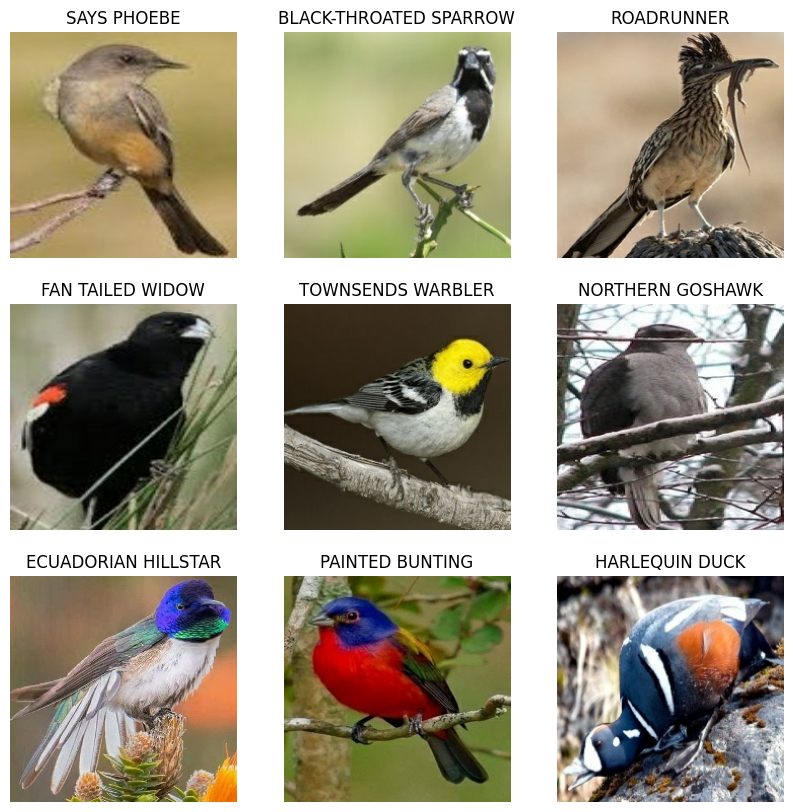

In [10]:

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## 3. Crear modelo con transfer learning: EfficientNetV2B3

In [12]:
# Cargar el modelo preentrenado EfficientNetV2B3
base_model = EfficientNetV2B3(weights='imagenet',
                              include_top=False,
                              input_shape=(img_height, img_width,3),
                              include_preprocessing=False)

# Congelar las capas del modelo base
base_model.trainable = False

# Construir el modelo
model = Sequential([
    Input(shape=(img_height, img_width,3)),
    Rescaling(1./255, input_shape=(img_height, img_width,3)), # Reescalar como parte del modelo
    base_model,
    GlobalAveragePooling2D(name="average_pooling"),
    Dropout(0.01),
    Dense(class_num, activation='softmax')
])

52606240/52606240 [==============================] - 3s 0us/step


In [13]:
# Definir el optimizador y la función de pérdida
base_learning_rate = 0.001
optimizer = Adam(learning_rate=base_learning_rate)
loss_function = SparseCategoricalCrossentropy()

# Compilar el modelo
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 7, 7, 1536)        12930622  
 nal)                                                            
                                                                 
 average_pooling (GlobalAve  (None, 1536)              0         
 ragePooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 525)               806925    
                                                                 
Total params: 13737547 (52.40 MB)
Trainable params: 8069

In [15]:
image_batch, label_batch = next(iter(train_dataset))
# Pasar el lote de imágenes a través del modelo para obtener el lote de características
feature_model = Model(inputs=model.input, outputs=model.output)
feature_batch = feature_model.predict(image_batch)

# Imprimir la forma del lote de características
print(feature_batch.shape)

1/1 [==============================] - 4s 4s/step
(32, 525)


In [16]:
# Callbacks: Definir Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True,
                               min_delta=0.001)

In [17]:
epochs = 30

In [ ]:
%time history = model.fit(train_dataset, epochs=epochs,validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/30
2120/2120 [==============================] - 7175s 3s/step - loss: 1.8321 - accuracy: 0.6271 - val_loss: 0.8113 - val_accuracy: 0.8142
Epoch 2/30
2120/2120 [==============================] - 115s 54ms/step - loss: 0.7600 - accuracy: 0.8183 - val_loss: 0.6155 - val_accuracy: 0.8526
Epoch 3/30
2120/2120 [==============================] - 114s 54ms/step - loss: 0.5549 - accuracy: 0.8640 - val_loss: 0.5436 - val_accuracy: 0.8650
Epoch 4/30
2120/2120 [==============================] - 115s 54ms/step - loss: 0.4517 - accuracy: 0.8850 - val_loss: 0.5008 - val_accuracy: 0.8716
Epoch 5/30
2120/2120 [==============================] - 115s 54ms/step - loss: 0.3846 - accuracy: 0.9011 - val_loss: 0.4814 - val_accuracy: 0.8783
Epoch 6/30
2120/2120 [==============================] - 116s 54ms/step - loss: 0.3315 - accuracy: 0.9138 - val_loss: 0.4637 - val_accuracy: 0.8816
Epoch 7/30
2120/2120 [==============================] - 115s 54ms/step - loss: 0.2940 - accuracy: 0.9225 - val_loss: 0.

In [ ]:
# Guardar el modelo en Google Drive
model.save("/content/drive/My Drive/birds_classification/modelos/birds_classification_model4.h5")

# Guardar el historial de entrenamiento en Google Drive
with open("/content/drive/My Drive/birds_classification/modelos/historial_birds_classification_model4.json", "w") as json_file:
    json.dump(history.history, json_file)


## 4. Visualizar resultados del entrenamiento

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

# Crear una figura con tamaño personalizado
plt.figure(figsize=(12, 6))

# Graficar accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim([0, 1.1])  # Establecer límites para el eje y entre 0 y 1.1
plt.grid(True)
plt.title('Training and Validation Accuracy')

# Graficar pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.title('Training and Validation Loss')

# Mostrar el gráfico
plt.show()

## 5. Evaluar el modelo

In [ ]:
Loss, Accuracy = model.evaluate(test_dataset)

print("    Validation Loss: {:.5f}".format(Loss))
print("Validation Accuracy: {:.2f}%".format(Accuracy * 100))